In [5]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [11]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/learning-datasets/sarcasm.json \
  -O /tmp/sarcasm.json

In [6]:
with open("/tmp/sarcasm.json") as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
training_sentences = sentences[0:20000]
testing_sentences = sentences[20000:]
training_labels = labels[0:20000]
testing_labels = labels[20000:]

In [8]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=100, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=100, padding='post', truncating='post')

In [9]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 19s - loss: 0.6630 - accuracy: 0.5889 - val_loss: 0.5818 - val_accuracy: 0.7982 - 19s/epoch - 30ms/step
Epoch 2/30
625/625 - 4s - loss: 0.4287 - accuracy: 0.8332 - val_loss: 0.3839 - val_accuracy: 0.8405 - 4s/epoch - 7ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3128 - accuracy: 0.8737 - val_loss: 0.3542 - val_accuracy: 0.8495 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2611 - accuracy: 0.8984 - val_loss: 0.3414 - val_accuracy: 0.8572 - 3s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.2246 - accuracy: 0.9118 - val_loss: 0.3430 - val_accuracy: 0.8575 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1997 - accuracy: 0.9240 - val_loss: 0.3516 - val_accuracy: 0.8508 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1770 - accuracy: 0.9332 - val_loss: 0.3772 - val_accuracy: 0.8450 - 3s/epoch - 5ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1572 - accuracy: 0.9414 - val_loss: 0.3949 - val_accuracy: 0.8411 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 - 

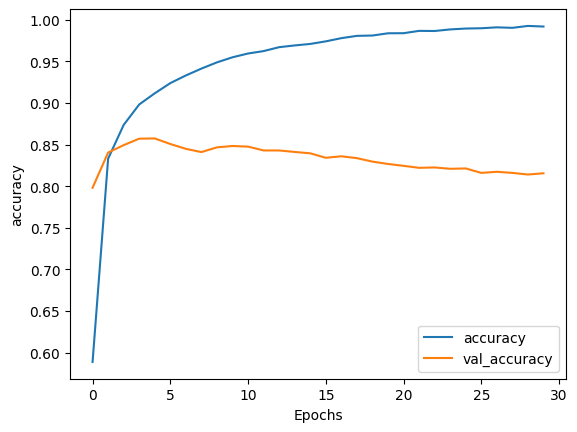

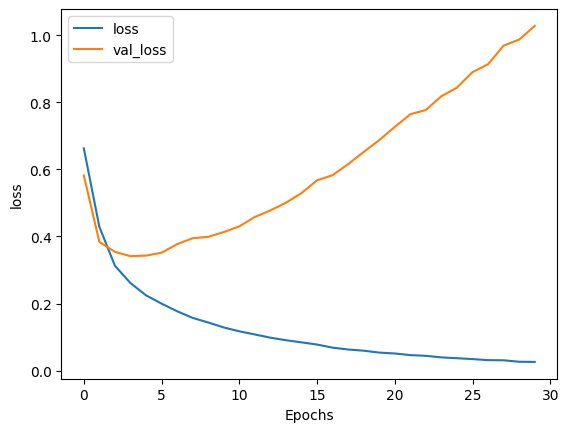

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(testing_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> announce 2011 newborns are <OOV> babies in 30 years ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [21]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [22]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for word_num in range(1, 10000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join(map(str, embeddings)) + '\n')

out_v.close()
out_m.close()

In [23]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vectors.tsv')
  files.download('metadata.tsv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
sentence = ['granny starting to fear spiders in the garden might be real', 'game of thrones season finale showing this sunday night']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
print(model.predict(padded))

1/1 [==============================] - 0s 107ms/step
[[9.5935041e-01]
 [5.0478084e-05]]
